In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from operator import attrgetter
from datetime import datetime, timedelta
import sys
sys.path.append('../')

from revolut_tools.timeseries_processing import generate_daily_transactions_df, generate_notication_actions_df,\
                                                add_user_cohort_info, add_engagement_to_daily_transactions

import statsmodels.stats.api as sms

In [2]:
FEATURES =  [
    'brand',
   'birth_year', 'country',
   'user_settings_crypto_unlocked', 'plan',
   'attributes_notifications_marketing_push',
   'attributes_notifications_marketing_email', 'num_contacts',
   'num_referrals', 'num_successful_referrals'
]

FEATURES_CATEGORICAL = ['brand', 'country', 'plan'] #'city'

ENGAGEMENT_PERIODS = [3,7,15]

In [3]:
devices = pd.read_csv('../data/rev-devices.csv')
notifications = pd.read_csv('../data/rev-notifications.csv')
transactions = pd.read_csv('../data/rev-transactions.csv')
users = pd.read_csv('../data/rev-users.csv')

In [4]:
transactions['created_date'] = pd.to_datetime(transactions['created_date'])
users['created_date'] = pd.to_datetime(users['created_date'])
notifications['created_date'] = pd.to_datetime(notifications['created_date'])

# EDA

## Analyze null values

In [5]:
users.isnull().sum()

user_id                                        0
birth_year                                     0
country                                        0
city                                           0
created_date                                   0
user_settings_crypto_unlocked                  0
plan                                           0
attributes_notifications_marketing_push     6610
attributes_notifications_marketing_email    6610
num_contacts                                   0
num_referrals                                  0
num_successful_referrals                       0
dtype: int64

There seem to be some nulls on the notification preferences. I will fill those depending on wether that user got that type or notification or not.

In [6]:
for notification_type in ['email', 'push']:
    user_notifications = users.merge(notifications, on='user_id', how='left')
    
    to_fill_feat = 'attributes_notifications_marketing_{}'.format(notification_type)
    notification_column = '{}_notification'.format(notification_type)
    

    user_notifications[
        notification_column
    ] = user_notifications['channel']=='{}'.format(notification_type.upper())

    users_got_notification = (
        user_notifications.groupby('user_id')[notification_column].sum()>=1
    ).to_dict()

    users.loc[users[to_fill_feat].isnull(), to_fill_feat] = (
        users.loc[
            users[to_fill_feat].isnull(), 'user_id'
        ].apply(lambda x: int(users_got_notification[x]))
    )

In [7]:
users.isnull().sum()

user_id                                     0
birth_year                                  0
country                                     0
city                                        0
created_date                                0
user_settings_crypto_unlocked               0
plan                                        0
attributes_notifications_marketing_push     0
attributes_notifications_marketing_email    0
num_contacts                                0
num_referrals                               0
num_successful_referrals                    0
dtype: int64

In [8]:
notifications.isnull().sum()

reason          0
channel         0
status          0
user_id         0
created_date    0
dtype: int64

In [9]:
transactions.isnull().sum()

transaction_id                 0
transactions_type              0
transactions_currency          0
amount_usd                     0
transactions_state             0
ea_cardholderpresence    1170594
ea_merchant_mcc          1158658
ea_merchant_city         1158794
ea_merchant_country      1158979
direction                      0
user_id                        0
created_date                   0
dtype: int64

In [10]:
transactions.loc[transactions['transactions_type'] == 'TRANSFER', 'ea_merchant_mcc'].isnull().mean()

1.0

In [11]:
transactions.loc[transactions['transactions_type'] == 'CARD_PAYMENT', 'ea_merchant_mcc'].isnull().mean()

0.0

Some of the transaction iformation seems to be missing for a lot of transactions. However this seems to be the normal behaviour of the feature as all of the transactions_type transfer don't have any information on this fields.

## Analyze Data volumes through time

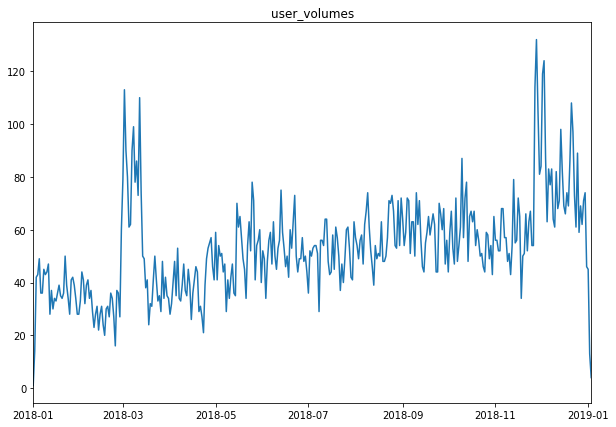

In [12]:
plt.figure(figsize=[10,7])
pd.to_datetime(users.created_date).dt.date.value_counts().plot()
plt.title('user_volumes')
plt.show()

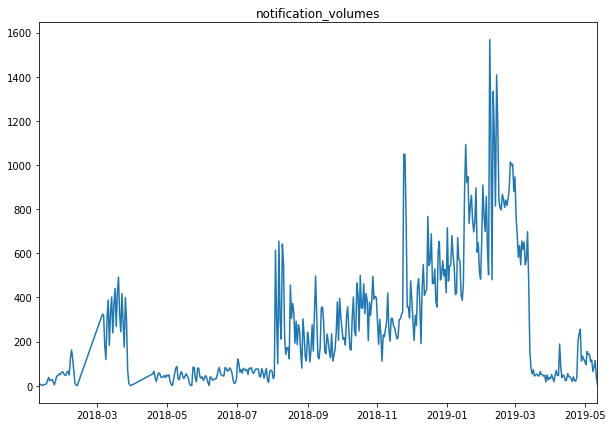

In [13]:
plt.figure(figsize=[10,7])
pd.to_datetime(notifications.created_date).dt.date.value_counts().plot()
plt.title('notification_volumes')
plt.show()

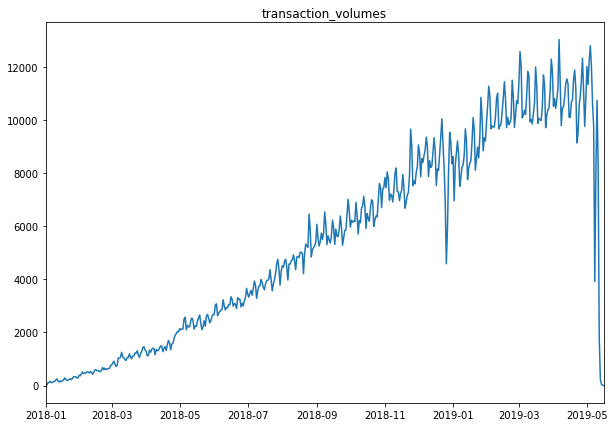

In [14]:
plt.figure(figsize=[10,7])
pd.to_datetime(transactions.created_date).dt.date.value_counts().plot()
plt.title('transaction_volumes')
plt.show()

In [15]:
# Transaction data seems to have a bid drop on the last observation dates. 
# This could be to some delay on this data.
# We will drop this days of information to prevent the efect of censoring the rest of the users.

# what is the lattest day we see transactions at?
transactions.created_date.dt.date.value_counts().tail(10)

2018-01-13    134
2018-01-06    117
2018-01-04    111
2018-01-07    109
2018-01-03    106
2019-05-14     46
2018-01-02     17
2019-05-15     11
2018-01-01      3
2019-05-16      1
Name: created_date, dtype: int64

In [16]:
# 2019-05-11 seems to be the last date with relevant levels of transactions data
analysis_end_date = pd.to_datetime('2019-05-11')

transactions = transactions[transactions['created_date']<=analysis_end_date]
notifications = notifications[notifications['created_date']<=analysis_end_date]

We seem to have data for all members created during 2018 and their transactions and notifications from the start of 2018 to the middle of 2019.

In [17]:
#Drop failed notifications
notifications = notifications[notifications['status']=='SENT']

# Question 2

***Define a target metric to measure user engagement. How would you define an engaged vs. unengaged user?***


Given the data that I was haddled the best way to measure engagement is:

- Number of transaction that a user makes after getting one of the engagement notifications we are given.

Now given this metric there is some analysis to be made to define:
1. What is the interval of days after the notifications that we should look for a transaction to happen.
2. What number of transactions after notification should make a user unengaged.

### Seasonal effect

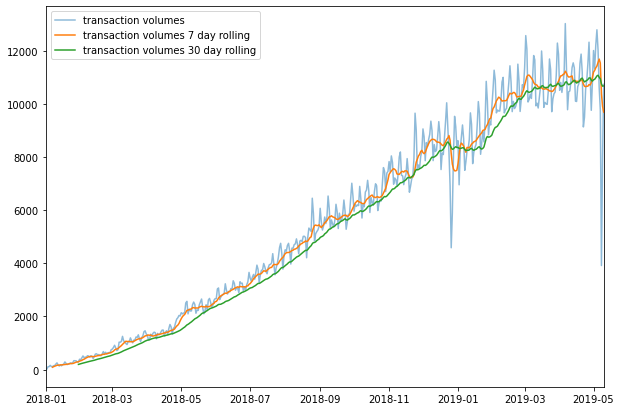

In [18]:
plt.figure(figsize=[10,7])

vals = transactions.created_date.dt.date.value_counts().sort_index()
vals.plot(alpha=0.5, label='transaction volumes')
vals.rolling(7).mean().plot(label='transaction volumes 7 day rolling')
vals.rolling(30).mean().plot(label='transaction volumes 30 day rolling')
plt.legend()
plt.show()

One first relevant insight is that transactions seem to have a 7 day seasonal effect. Calculating the the 7 day average of the transaction volumes highly smoothens the curve. This means that user behaviour varies through the week.

### Transaction interval

I want to get a better understanding of the intervals between users transactions. In order to do so I will plot the CDF of the transaction interval times and get the description of the quatile values of it.

To do so first I am going to process the data to have a more convevient view of the information we have.
I have created the generate_daily_transactions_dataframe that process the users and transactiondata to give us a time series view of the number of actions per user a day:

In [19]:
daily_transactions = generate_daily_transactions_df(users, transactions, analysis_end_date)

In [20]:
daily_transactions.head()

,user_id,days_alive,date,transaction_number
0,user_0,1,2018-01-14,0.0
1,user_0,2,2018-01-15,0.0
2,user_0,3,2018-01-16,5.0
3,user_0,4,2018-01-17,2.0
4,user_0,5,2018-01-18,12.0


Now we will calculate the transaction interval:

In [21]:
# TODO: Put in a function

daily_transactions_with_action = daily_transactions.loc[
    daily_transactions['transaction_number']>0
].copy()

daily_transactions_with_action[
    'transaction_interval'
] = daily_transactions_with_action.groupby('user_id')['days_alive'].diff()

# Fill the initial null value for each member with the number of days alive
daily_transactions_with_action.loc[
    daily_transactions_with_action['transaction_interval'].isnull(),
    'transaction_interval'
] = daily_transactions_with_action['days_alive']

[]

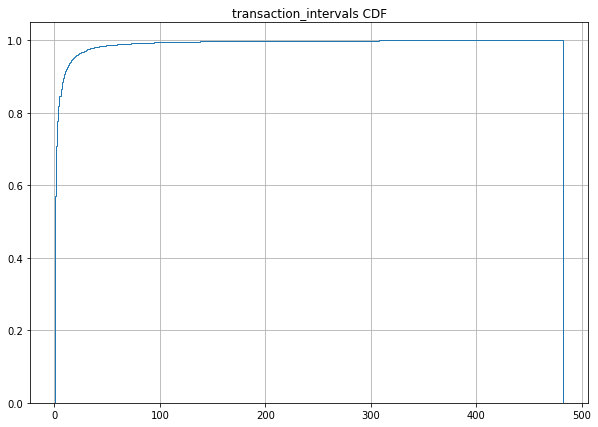

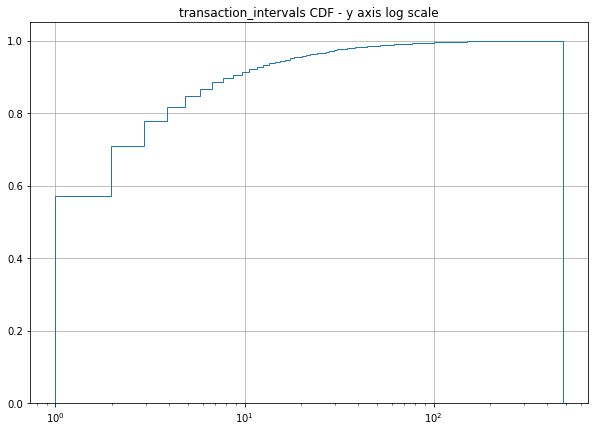

In [22]:
plt.figure(figsize=[10,7])
daily_transactions_with_action['transaction_interval'].hist(
    cumulative=True, 
    histtype='step',
    bins=500, 
    density=1
)
plt.title('transaction_intervals CDF')
plt.plot()

plt.figure(figsize=[10,7])
daily_transactions_with_action['transaction_interval'].hist(
    cumulative=True, 
    histtype='step', 
    bins=500, 
    density=1
)
plt.xscale('log')
plt.title('transaction_intervals CDF - y axis log scale')
plt.plot()

In [23]:
daily_transactions_with_action['transaction_interval'].describe([i/100 for i in range(1,100,5)])

count    870504.000000
mean          4.893104
std          15.541058
min           1.000000
1%            1.000000
6%            1.000000
11%           1.000000
16%           1.000000
21%           1.000000
26%           1.000000
31%           1.000000
36%           1.000000
41%           1.000000
46%           1.000000
50%           1.000000
51%           1.000000
56.0%         1.000000
61%           2.000000
66%           2.000000
71%           3.000000
76%           3.000000
81%           4.000000
86%           6.000000
91%          10.000000
96%          22.000000
max         482.000000
Name: transaction_interval, dtype: float64

In [24]:
daily_transactions_with_action['transaction_interval'].quantile(0.87)

7.0

We are looking at the days interval between the days with transactions. This means that we are assuming that multiple transactions on the same day don't represent any proof of engagement.

The analysis has an exponential distribuition as it is expected for a distribution of time intervals of a particular event. Given this reality and the fact that 7 day inaction is seen only 12% of the times. I think It would be sensible to define an unanegaged user as that one that doesn't act 7 days after a given date.

***Note:*** I have seen that transaction interval times highly vary accross groups (specially on membership types) In the future we could model the transaction interval time and have a different definition for unengaged for each user.

### Explore notification actions

In [25]:
# Look at the number of actions that each notification had X days after
for days_to_check in [1,3,7,15]:
    notification_actions = generate_notication_actions_df(notifications, transactions, days_to_check)
    
    print ('{}% of the user are engaged checking actions {} days after'.format(
        (notification_actions.engaged.mean()*100).round(2), days_to_check
    )
          )

    print(notification_actions.groupby('reason')['action_count'].mean())

29.43% of the user are engaged checking actions 1 days after
reason
BLACK_FRIDAY                            3.123358
ENGAGEMENT_SPLIT_BILL_RESTAURANT        6.440699
FIFTH_PAYMENT_PROMO                     1.734245
JOINING_ANNIVERSARY                     1.628544
LOST_CARD_ORDER                         0.889344
MADE_MONEY_REQUEST_NOT_SPLIT_BILL       3.674782
METAL_GAME_START                        1.449154
METAL_RESERVE_PLAN                      2.357032
NO_INITIAL_CARD_ORDER                   0.769334
NO_INITIAL_CARD_USE                     0.481914
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER    0.291680
ONBOARDING_TIPS_ACTIVATED_USERS         3.087551
PREMIUM_ENGAGEMENT_FEES_SAVED           4.646520
PREMIUM_ENGAGEMENT_INACTIVE_CARD        0.430208
PUMPKIN_PAYMENT_NOTIFICATION            3.302281
REENGAGEMENT_ACTIVE_FUNDS               0.437613
WELCOME_HOME                            1.808190
Name: action_count, dtype: float64
39.97% of the user are engaged checking actions 3 days after
rea

7 days space to act after the notification gets shown makes 52.65% of the users engaged at any point in time. This seems like a reasonable amout.

Therefore we will define as unengaged those users that don't have any actions 7 days after we sent them the notification

In [26]:
notification_actions = generate_notication_actions_df(notifications, transactions, 7)

## Question 3

***Using your logic from above, build a model (heuristic/statistical/ML) to classify engaged and unengaged users***

Now given the engaged and with the features that we have of each customer at all the observations points where they got notifications we are going to try to predict if they will churn or not.

We will use all the data from:

- Users
- Devices
- transactions made in the past

We will fit 3 classification models with Gridsearch and try to optimize the best parameters to each model and then compare their Roc curves.

### Generate target and features

In [28]:
for engagement_period in ENGAGEMENT_PERIODS:
    daily_transactions = add_engagement_to_daily_transactions(daily_transactions, engagement_period)
    FEATURES = FEATURES + ['last_{}_days_transactions'.format(engagement_period)]

In [29]:
# Only use notification actions to fit the data.
notification_actions_features = add_user_cohort_info(
    notification_actions, 
    users, 
    'created_date_notification'
)

# Merge the features from other tables
notification_actions_features = notification_actions_features.merge(devices)
notification_actions_features = notification_actions_features.merge(users)

# Merge daily transactions information
notification_actions_features = notification_actions_features.merge(
    daily_transactions, 
    on=['user_id', 'days_alive']
)

X = notification_actions_features[FEATURES]

model_dummy_dict = {}

for feat in FEATURES_CATEGORICAL:
    dummies = pd.get_dummies(X[feat], drop_first=True)
    model_dummy_dict[feat] = list(dummies.columns)
    
    X = pd.concat([X, dummies], axis=1)
    X.drop(feat, axis=1, inplace=True)

y = notification_actions_features['engaged']

### Fit models

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from revolut_tools.model_results import scores, opt_plots

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

We split the data on train, test and development samples

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.2)

Baseline: 0.5255652473315735
train: 0.77 test: 0.77
Best params:  {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}


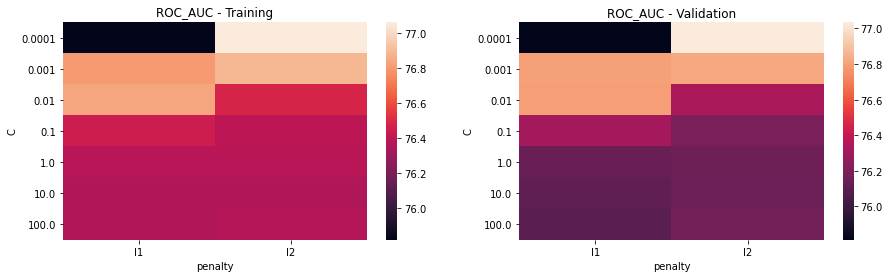

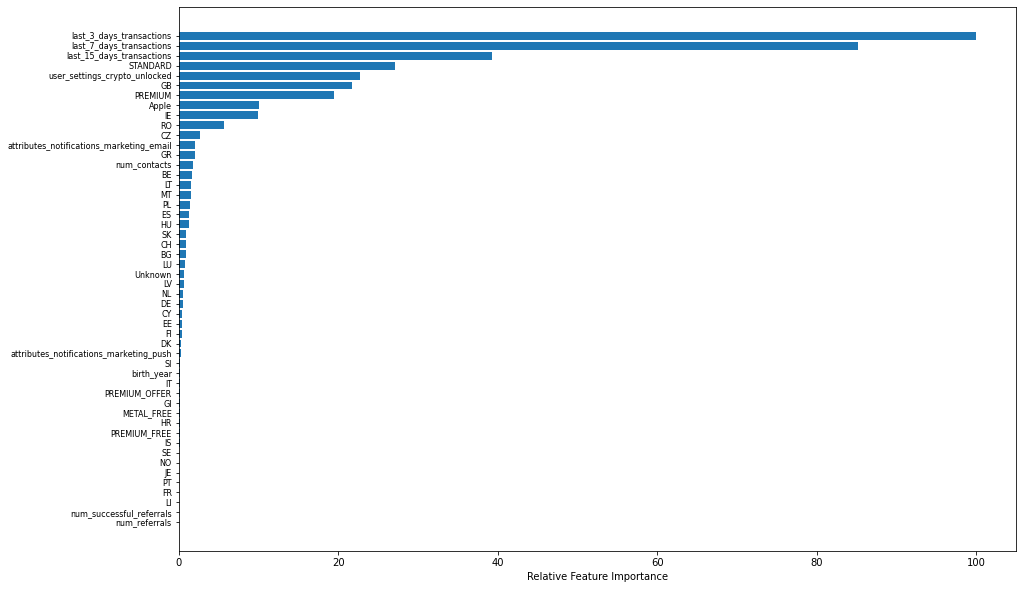

In [33]:
logreg = LogisticRegression()
param_grid = {
    "C":np.logspace(-4,2,7), 
    "penalty":["l1","l2"], 
    'solver':['liblinear']
}

opt_model = GridSearchCV(
    logreg,
    param_grid,
    cv=skf,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1
)
opt_model.fit(X_train_v,y_train_v)
logreg_best = opt_model.best_estimator_


print('Baseline:', y.mean())
scores(logreg_best,X_train_v,X_val,y_train_v,y_val)
print('Best params: ', opt_model.best_params_)
opt_plots(opt_model)

#Feature importance
feature_importance = abs(logreg_best.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=[15,10])
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

Baseline: 0.5255652473315735
train: 0.83 test: 0.76
Best params:  {'leaf_size': 11, 'n_neighbors': 11, 'p': 1}


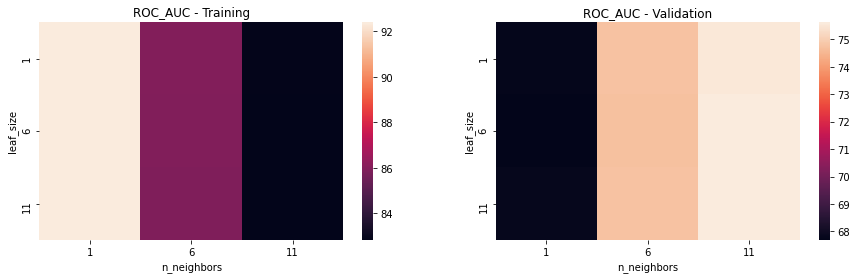

In [34]:
knn = KNeighborsClassifier()

leaf_size = list(range(1,15,5))
n_neighbors = list(range(1,15,5))
p=[1,2]
param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

opt_model = GridSearchCV(
    knn,
    param_grid,
    cv=skf,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1
)
opt_model.fit(X_train_v,y_train_v)
knn_best = opt_model.best_estimator_


print('Baseline:', y.mean())
scores(knn_best,X_train_v,X_val,y_train_v,y_val)
print('Best params: ', opt_model.best_params_)
opt_plots(opt_model)

Baseline: 0.5255652473315735
train: 0.82 test: 0.79
Best params:  {'max_depth': 30, 'min_samples_leaf': 10}


Text(0.5, 0, 'Relative Importance')

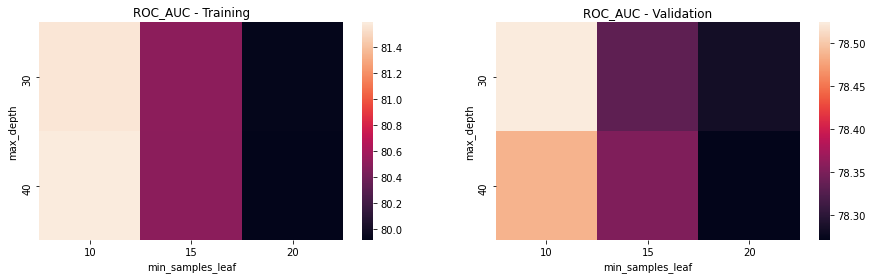

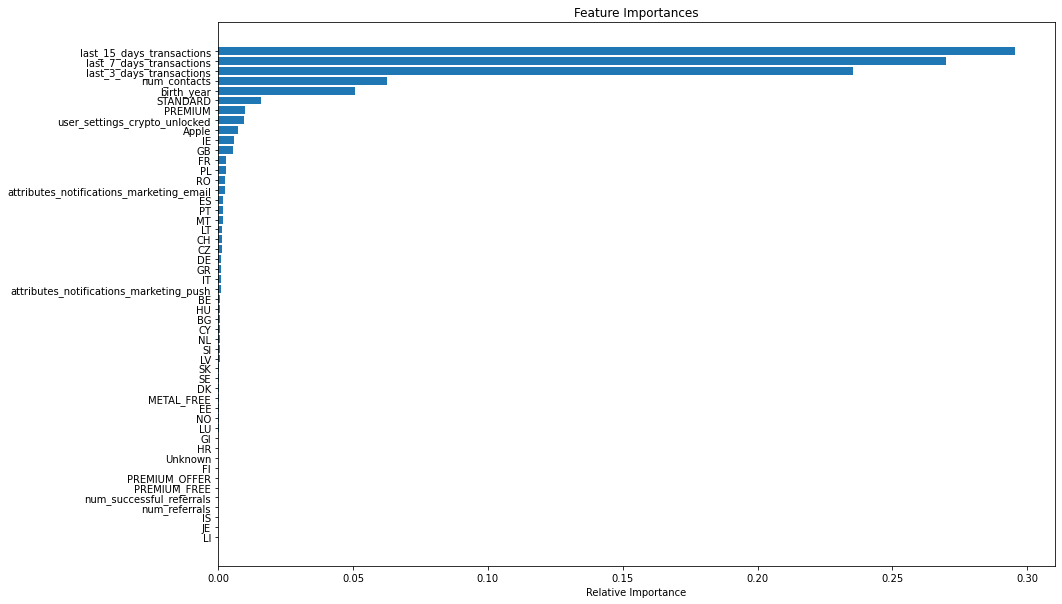

In [35]:
rf = RandomForestClassifier()
param_grid = {
    'max_depth':range(30, 40+1, 10),
    'min_samples_leaf':[10, 15, 20]
}

opt_model = GridSearchCV(
    rf,
    param_grid,
    cv=skf,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1
)
opt_model.fit(X_train_v,y_train_v)
rf_best = opt_model.best_estimator_

print('Baseline:', y.mean())
scores(rf_best,X_train_v,X_val,y_train_v,y_val)
print('Best params: ', opt_model.best_params_)
opt_plots(opt_model)


# Feature importance
features_X=X.columns
importances = rf_best.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=[15,10])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features_X[indices])
plt.xlabel('Relative Importance')

No Skill: ROC AUC=0.500
knn: ROC AUC=0.75
rf: ROC AUC=0.78
logreg: ROC AUC=0.76


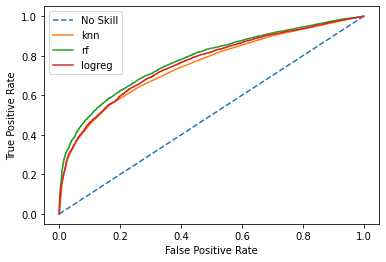

In [36]:
models = {
    'knn': knn_best, 
    'rf':rf_best, 
    'logreg':logreg_best,
}

most_common = int(y_test.mode().item())
ns_probs = [most_common for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

for clf_label, clf in models.items():

    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    print('{}: ROC AUC={}'.format(clf_label, round(lr_auc, 2)))
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(lr_fpr, lr_tpr, marker='', label='{}'.format(clf_label))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [37]:
# Test model on test data
test_prob = rf_best.predict_proba(X_test)[:,1]
final_score = roc_auc_score(y_test,test_prob)
print (round(final_score,2))

0.78


In [38]:
# Fit the model on the whole dataset
best_model = rf_best.fit(X, y)

### 4. 
***Let’s assume an unengaged user is a churned user. Now suppose we use your model to identify unengaged users and implement some business actions try to convert them to engaged users (commonly known as reducing churn)***

***a. How would you set up a test/experiment to check whether we are actually reducing churn?***

***b. What metrics and techniques would you use to assess the impact of the business action?***

In order to experiment with the model created in order to reduce churn I would create an AB test experiment where:

1. At a given point on time I would predict unengagement.
2. Get all the unengagement users and split them on 2.
3. Send a promotion notification to one of the groups. 
4. Measure the impact of the measure taken with a t-test hypothesis test on the relevant metrics.

(Joining anniversary seemed to increase engagement for users. I would recommend creating a promotion with similar conditions to whatever that one had but based on something that Revolut can celebrate. i.e. Revolut has reached 15 M users and we want to celebrate with you.)

As engagement is defined as transaction after notification the best success metric to check would be Average number of transactions 1, 7, and 15 days after.

I would recommed using 7 day average of transactions after the notification as the best success metric in order to analyze if users actually become more engagement on a medium term compare to just acting one time on the notification sent.

This part that follows is an example of the framework I am recommending:

### 1. Get unengaged users

In [39]:
analysis_date = pd.to_datetime('2018-11-01')
analysis_date_1minus = (analysis_date - timedelta(days=1)).date()

In [40]:
# Get daily transactions
daily_transactions = generate_daily_transactions_df(users, transactions, analysis_date)

# Get engagement features
for engagement_period in ENGAGEMENT_PERIODS:
    daily_transactions = add_engagement_to_daily_transactions(
        daily_transactions,
        engagement_period
    )

# Filter on the given date of analysis
daily_transactions = daily_transactions.loc[
    daily_transactions['date']==analysis_date_1minus
].copy()

#Add features
daily_transactions = daily_transactions.merge(devices)
daily_transactions = daily_transactions.merge(users)

X = daily_transactions[FEATURES].copy()

# Create the dummy variables needed to fit the model
for feat, dummies in model_dummy_dict.items():
    for dummmy in dummies:
        X[dummmy] = (X[feat]==dummmy).astype(int)
    X.drop(feat, axis=1, inplace=True)

#Predict unengagement
engaged_users = rf_best.predict(X).astype(int)

In [41]:
#Predict unengagement
engaged_users = rf_best.predict(X).astype(int)

In [42]:
engaged_users = pd.DataFrame(engaged_users)
engaged_users.columns = ['engaged']
engaged_users['user_id'] = daily_transactions['user_id']

### 2. Split the group on 2

In [43]:
unengaged_users = engaged_users.loc[engaged_users['engaged']==0, 'user_id']

### 3. Define experiment parameters

In [48]:
from revolut_tools.hypothesis_testing import test_mean_diff, exp_sample_size_needed

In [49]:
# calculate the baseline rate conversion looking at the past 7 days
# How many people transformed without any treatment?

# How many of these are actually active a week after
analysis_date_plus7 = (analysis_date + timedelta(days=7)).date()
analysis_date_plus6 = (analysis_date + timedelta(days=6)).date()

# Get daily transactions
daily_transactions = generate_daily_transactions_df(users, transactions, analysis_date_plus7)
daily_transactions = add_engagement_to_daily_transactions(daily_transactions, 7)

# Filter on the given date of analysis
daily_transactions = daily_transactions.loc[daily_transactions['date']==analysis_date_plus6].copy()

daily_transactions_unengaged_users = daily_transactions.loc[
    daily_transactions['user_id'].isin(unengaged_users.tolist())
]

baseline_rate = (daily_transactions_unengaged_users['last_7_days_transactions']>0).mean()

In [50]:
practical_significance = 0.025
confidence_level = 0.05
sensitivity = 0.8

In [51]:
exp_sample_size_needed(baseline_rate, practical_significance, confidence_level, sensitivity)

Required sample size:  3450  per group


Given the levels of sensitivity, confidence and practical_significance that we are looking for it looks there is enough observations on a given date to run the desired experiment.

If we didn't we could prolong the experiment on different days however this would mean sending various notifications to each user. This could have a confounding effect.

In [52]:
control_users = unengaged_users.sample(frac=0.5)

mask = np.logical_not(unengaged_users.isin(control_users))
experiment_users = unengaged_users[mask]

In [53]:
daily_transactions['group'] = 'control'
daily_transactions.loc[daily_transactions['user_id'].isin(experiment_users), 'group'] = 'treatment'

### 4. Send the promotion to both of the groups

Send the notification to the experiment group

### 5. Measure the impact

7 days after we sent the notifications we look into 

In [54]:
daily_transactions['converted'] = daily_transactions['last_7_days_transactions']>0
test_mean_diff(daily_transactions, confidence_level = 0.05, practical_significance = 0.025)

Do not reject the null hypothesis
The lower bound of the confidence interval is  -33.73 %
The upper bound of the confidence interval is  -30.39 %


Obviously in this case because we did not apply any actual treatment we do not reject the null hypothesis.

Once we apply the treatment we would analyze this same results and see if there is a statistical significance.